## Data gathering

In [1]:
!wget -q http://data.vision.ee.ethz.ch/ihnatova/camera_scene_detection_train.zip
!unzip -qq camera_scene_detection_train.zip

## Imports

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
from tqdm import tqdm
from imutils import paths
from pprint import pprint
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

tf.random.set_seed(42)
np.random.seed(42)

## Data parsing

In [3]:
image_paths = list(paths.list_images("training"))
np.random.shuffle(image_paths)
print(image_paths[:5])

['training/2_Group_portrait/221.jpg', 'training/29_QR_images/126.jpg', 'training/16_Blue_Sky/144.jpg', 'training/18_Greenery/157.jpg', 'training/22_Stage_concert/36.jpg']


In [4]:
labels = []
for image_path in tqdm(image_paths):
    label = image_path.split("/")[1]
    labels.append(label)
class_count = Counter(labels) 
pprint(class_count) 

100%|██████████| 9897/9897 [00:00<00:00, 611067.34it/s]

Counter({'4_Dog': 502,
         '14_Architecture': 463,
         '15_Sunset_Sunrise': 420,
         '7_Food': 400,
         '5_Cat': 373,
         '6_Macro': 357,
         '9_Mountain': 352,
         '11_Snow': 344,
         '12_Landscape': 335,
         '8_Beach': 334,
         '10_Waterfall': 326,
         '2_Group_portrait': 324,
         '16_Blue_Sky': 322,
         '22_Stage_concert': 322,
         '1_Portrait': 319,
         '23_Fireworks': 317,
         '21_Night_shot': 316,
         '24_Candle_light': 313,
         '30_Computer_Screens': 308,
         '17_Cloudy_Sky': 307,
         '28_Text_Documents': 306,
         '26_Indoor': 298,
         '13_Underwater': 296,
         '19_Autumn_leaves': 295,
         '18_Greenery': 294,
         '3_Kids': 281,
         '27_Backlight': 280,
         '20_Flower': 279,
         '25_Neon_lights': 269,
         '29_QR_images': 245})


## Define the hyparameters

In [5]:
TRAIN_SPLIT = 0.9
IMG_SIZE = 224
BATCH_SIZE = 128
AUTO = tf.data.AUTOTUNE
EPOCHS = 100
NUM_CLASSES = 30

## Split the dataset

In [6]:
i = int(len(image_paths) * TRAIN_SPLIT)

train_paths = image_paths[:i]
train_labels = labels[:i]
validation_paths = image_paths[i:]
validation_labels = labels[i:]

print(len(train_paths), len(validation_paths))

8907 990


## Encode the labels

In [7]:
le = LabelEncoder()
train_labels_le = le.fit_transform(train_labels)
validation_labels_le = le.transform(validation_labels)
print(train_labels_le[:5])

[21 20  6  8 13]


## Dataloader

In [8]:
@tf.function
def load_images(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) # No rescaling since MobileNetV3 internally does it
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return (image, label)

## Apply data augmentation

In [9]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
        tf.keras.layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

## Convert the data into TensorFlow Dataset objects

In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels_le))
val_ds = tf.data.Dataset.from_tensor_slices((validation_paths, validation_labels_le))

## Data pipeline

In [11]:
pipeline_train = (
    train_ds
    .shuffle(1024)
    .map(load_images, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

pipeline_validation = (
    val_ds
    .map(load_images, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## Determine class weights

In [12]:
trainLabels = keras.utils.to_categorical(train_labels_le)
classTotals = trainLabels.sum(axis=0)
classWeight = dict()
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]

## Model building and training

In [13]:
def get_training_model(trainable=False):
    # Load the MobileNetV3 model but exclude the classification layers
    EXTRACTOR = keras.applications.MobileNetV3Small(weights="imagenet", include_top=False,
                    input_shape=(IMG_SIZE, IMG_SIZE, 3))
    # We will set it to both True and False
    EXTRACTOR.trainable = trainable
    # Construct the head of the model that will be placed on top of the
    # the base model
    class_head = EXTRACTOR.output
    class_head = layers.GlobalAveragePooling2D()(class_head)
    class_head = layers.Dense(512, activation="relu")(class_head)
    class_head = layers.Dropout(0.5)(class_head)
    class_head = layers.Dense(NUM_CLASSES, activation="softmax", dtype="float32")(class_head)

    # Create the new model
    classifier = keras.Model(inputs=EXTRACTOR.input, outputs=class_head)

    # Compile and return the model
    classifier.compile(loss="sparse_categorical_crossentropy", 
                          optimizer="adam",
                          metrics=["accuracy"])

    return classifier

## Plot the metric

In [14]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()

## Setup callbacks

In [15]:
train_callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

## Train the model

6709248/6698480 [==============================] - 0s 0us/step
Epoch 1/100
70/70 [==============================] - 108s 1s/step - loss: 1.3390 - accuracy: 0.7752 - val_loss: 0.3438 - val_accuracy: 0.8980
Epoch 2/100
70/70 [==============================] - 89s 1s/step - loss: 0.4143 - accuracy: 0.9174 - val_loss: 0.3119 - val_accuracy: 0.8980
Epoch 3/100
70/70 [==============================] - 86s 1s/step - loss: 0.2999 - accuracy: 0.9402 - val_loss: 0.3081 - val_accuracy: 0.8929
Epoch 4/100
70/70 [==============================] - 88s 1s/step - loss: 0.2349 - accuracy: 0.9506 - val_loss: 0.2813 - val_accuracy: 0.9081
Epoch 5/100
70/70 [==============================] - 87s 1s/step - loss: 0.1989 - accuracy: 0.9581 - val_loss: 0.2873 - val_accuracy: 0.9091
Epoch 6/100
70/70 [==============================] - 87s 1s/step - loss: 0.1673 - accuracy: 0.9655 - val_loss: 0.2979 - val_accuracy: 0.9000
Epoch 7/100
70/70 [==============================] - 87s 1s/step - loss: 0.1539 - accuracy

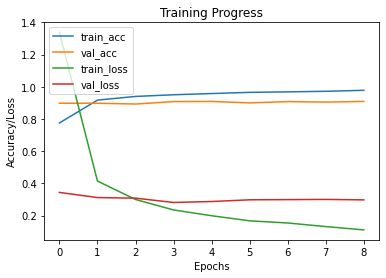

In [16]:
classifier = get_training_model()

h = classifier.fit(pipeline_train,
               validation_data=pipeline_validation,
               epochs=EPOCHS,
               class_weight=classWeight,
               callbacks=train_callbacks)

accuracy = classifier.evaluate(pipeline_validation)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))
plot_hist(h)

## Serialize the model

In [17]:
classifier.save('image_scene_model')

INFO:tensorflow:Assets written to: image_scene_model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [18]:
!tar -cvf "image_scene_model.tar" "image_scene_model"

image_scene_model/
image_scene_model/keras_metadata.pb
image_scene_model/saved_model.pb
image_scene_model/assets/
image_scene_model/variables/
image_scene_model/variables/variables.index
image_scene_model/variables/variables.data-00000-of-00001
